<a href="https://colab.research.google.com/github/inconw/ProjectPortfolio/blob/main/M3_IngridConway.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone 3
Ingrid Conway
November 30, 2020


# Introduction

This semester's milestone uses data collected for the semiconductor industry to the disposable diaper industry. Disposable diapers make up a vast industry. In 1996 diaper sales exceeded $4 billion in the U.S. alone ('Disposable Diaper'). With the advances in computing power in recent decades, the potential gains from well done data analytics are immense. 

The disposable diaper industry has continued to evolve since its inception in the early-1970s. Today's diapers are highly functional and efficient for households compared to traditional clothe diapers. Contemporary diapers include advanced features like special sizing and coloring for specific ages or different genders ('Disposable Diaper'). Above all, the single most important property of a diaper is its ability to absorb and retain moisture. Today's most advanced diapers absorb 15 times their weight in liquid.

While the vast majority of diapers function perfectly, there is always a small portion with some defect. The aim of this project is to construct AI models for the diaper manufacturer to predict the occurance of a faulty diaper.



"Disposable Diaper." madehow.com. Retrieved Sept. 2020, from http://www.madehow.com/Volume-3/Disposable-Diaper.html#google_vignette






In [ ]:
# First, we import the necessary libraries.
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer

from sklearn import svm, metrics, datasets
from sklearn.metrics import classification_report

import tensorflow as tf

In [ ]:
# enable GPU for neural network training speedup
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')
print(device_name)


/device:GPU:0


# Prepare Data

In [ ]:
# When reading in file, must force it to not read a header row
# The csv file contains no header
label = pd.read_csv("secom_labels.data", header=None)
print(f'label csv file shape (rows, columns): {label.shape}')
label.head(3)

label csv file shape (rows, columns): (1567, 1)


,0
0,"-1 ""19/07/2008 11:55:00"""
1,"-1 ""19/07/2008 12:32:00"""
2,"1 ""19/07/2008 13:17:00"""


In [ ]:
# split on the quotation mark, not on the spaces
# Splitting on spaces splits the datetime, which we don't want
label = label[0].str.split('"', expand = True)
label.head(3)

,0,1,2
0,-1,19/07/2008 11:55:00,
1,-1,19/07/2008 12:32:00,
2,1,19/07/2008 13:17:00,


In [ ]:
# Drop the column labelled 2, because that column is empty
label.drop([2], axis='columns', inplace=True)
# relabel columns 1 and 2
label.columns = ['passFail', 'datetime']
label.head(3)

,passFail,datetime
0,-1,19/07/2008 11:55:00
1,-1,19/07/2008 12:32:00
2,1,19/07/2008 13:17:00


In [ ]:
# convert datetime string into datetime object
from dateutil.parser import parse
label['datetime'] = label['datetime'].apply(parse)
print(label.dtypes)
label.head(3)

passFail            object
datetime    datetime64[ns]
dtype: object


,passFail,datetime
0,-1,2008-07-19 11:55:00
1,-1,2008-07-19 12:32:00
2,1,2008-07-19 13:17:00


In [ ]:
# convert passFail to number, and convert -1 to zero, so only have labels 0 and 1
label['passFail'] = label['passFail'].astype(int) 
label['passFail'] = label['passFail'].map({0:0, -1:0, 1:1}) # changed -1 to a zero; 1 stays a 1; 0 stays 0
print(label.info())
print(f'\nCount of passFail labels:\n{label["passFail"].value_counts()}\n')
label.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   passFail  1567 non-null   int64         
 1   datetime  1567 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 24.6 KB
None

Count of passFail labels:
0    1463
1     104
Name: passFail, dtype: int64



,passFail,datetime
0,0,2008-07-19 11:55:00
1,0,2008-07-19 12:32:00
2,1,2008-07-19 13:17:00


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
# Reading in sensor reading data
# When reading in file, must force it to not read a header row
# The csv file contains no header
# Also, make the delimiter=" ", because the rows are separated by a space instead 
# of the default columns.  
secom = pd.read_csv("secom.data", header=None, delimiter=" " )
print(f'secom csv file shape (rows, columns): {secom.shape}')
secom.head(3)

secom csv file shape (rows, columns): (1567, 590)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,-0.0034,0.9455,202.4396,0.0,7.9558,414.8710,10.0433,0.9680,192.3963,12.5190,1.4026,-5419.00,2916.50,-4043.75,751.00,0.8955,1.7730,3.0490,64.2333,2.0222,0.1632,3.5191,83.3971,9.5126,50.6170,64.2588,49.3830,66.3141,86.9555,117.5132,...,12.93,0.78,0.1827,5.7349,0.3363,39.8842,3.2687,1.0297,1.0344,0.4385,0.1039,42.3877,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,533.8500,2.1113,8.95,0.3157,3.0624,0.1026,1.6765,14.9509,NaN,NaN,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,-0.0148,0.9627,200.5470,0.0,10.1548,414.7347,9.2599,0.9701,191.2872,12.4608,1.3825,-5441.50,2604.25,-3498.75,-1640.25,1.2973,2.0143,7.3900,68.4222,2.2667,0.2102,3.4171,84.9052,9.7997,50.6596,64.2828,49.3404,64.9193,87.5241,118.1188,...,16.00,1.33,0.2829,7.1196,0.4989,53.1836,3.9139,1.7819,0.9634,0.1745,0.0375,18.1087,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,535.0164,2.4335,5.92,0.2653,2.0111,0.0772,1.1065,10.9003,0.0096,0.0201,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,0.0013,0.9615,202.0179,0.0,9.5157,416.7075,9.3144,0.9674,192.7035,12.5404,1.4123,-5447.75,2701.75,-4047.00,-1916.50,1.3122,2.0295,7.5788,67.1333,2.3333,0.1734,3.5986,84.7569,8.6590,50.1530,64.1114,49.8470,65.8389,84.7327,118.6128,...,16.16,0.85,0.0857,7.1619,0.3752,23.0713,3.9306,1.1386,1.5021,0.3718,0.1233,24.7524,267.064,0.9032,1.1,0.6219,0.4122,0.2562,0.4119,68.8489,535.0245,2.0293,11.21,0.1882,4.0923,0.0640,2.0952,9.2721,0.0584,0.0484,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602


In [ ]:
# DO not need to do this str.split because read in file above with delimiter=" "
#secom.columns = ['sensorReading']
#secom = secom.sensorReading.str.split(expand = True)
#print(f'secom csv file shape (rows, columns): {secom.shape}')
#secom.head(3)

In [ ]:
#Merging label and secom
#secomMerged = label.append(secom)
secomMerged = pd.concat([label, secom], axis = 1)
print(f'merged dataframe shape (rows, columns): {secomMerged.shape}')
secomMerged.head(5)

merged dataframe shape (rows, columns): (1567, 592)


,passFail,datetime,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589
0,0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,-0.0034,0.9455,202.4396,0.0,7.9558,414.8710,10.0433,0.9680,192.3963,12.5190,1.4026,-5419.00,2916.50,-4043.75,751.00,0.8955,1.7730,3.0490,64.2333,2.0222,0.1632,3.5191,83.3971,9.5126,50.6170,64.2588,49.3830,66.3141,...,12.93,0.78,0.1827,5.7349,0.3363,39.8842,3.2687,1.0297,1.0344,0.4385,0.1039,42.3877,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,533.8500,2.1113,8.95,0.3157,3.0624,0.1026,1.6765,14.9509,NaN,NaN,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,0,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,-0.0148,0.9627,200.5470,0.0,10.1548,414.7347,9.2599,0.9701,191.2872,12.4608,1.3825,-5441.50,2604.25,-3498.75,-1640.25,1.2973,2.0143,7.3900,68.4222,2.2667,0.2102,3.4171,84.9052,9.7997,50.6596,64.2828,49.3404,64.9193,...,16.00,1.33,0.2829,7.1196,0.4989,53.1836,3.9139,1.7819,0.9634,0.1745,0.0375,18.1087,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,535.0164,2.4335,5.92,0.2653,2.0111,0.0772,1.1065,10.9003,0.0096,0.0201,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,1,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,0.0013,0.9615,202.0179,0.0,9.5157,416.7075,9.3144,0.9674,192.7035,12.5404,1.4123,-5447.75,2701.75,-4047.00,-1916.50,1.3122,2.0295,7.5788,67.1333,2.3333,0.1734,3.5986,84.7569,8.6590,50.1530,64.1114,49.8470,65.8389,...,16.16,0.85,0.0857,7.1619,0.3752,23.0713,3.9306,1.1386,1.5021,0.3718,0.1233,24.7524,267.064,0.9032,1.10,0.6219,0.4122,0.2562,0.4119,68.8489,535.0245,2.0293,11.21,0.1882,4.0923,0.0640,2.0952,9.2721,0.0584,0.0484,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,0,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,-0.0033,0.9629,201.8482,0.0,9.6052,422.2894,9.6924,0.9687,192.1557,12.4782,1.4011,-5468.25,2648.25,-4515.00,-1657.25,1.3137,2.0038,7.3145,62.9333,2.6444,0.2071,3.3813,84.9105,8.6789,50.5100,64.1125,49.4900,65.1951,...,131.68,39.33,0.6812,56.9303,17.4781,161.4081,35.3198,54.2917,1.1613,0.7288,0.2710,62.7572,268.228,0.6511,7.32,0.1630,3.5611,0.0670,2.7290,25.0363,530.5682,2.0253,9.33,0.1738,2.8971,0.0525,1.7585,8.5831,0.0202,0.0149,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,0,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,-0.0072,0.9569,201.9424,0.0,10.5661,420.5925,10.3387,0.9735,191.6037,12.4735,1.3888,-5476.25,2635.25,-3987.50,117.00,1.2887,1.9912,7.2748,62.8333,3.1556,0.2696,3.2728,86.3269,8.7677,50.2480,64.1511,49.7520,66.1542,...,19.63,1.98,0.4287,9.7608,0.8311,70.9706,4.9086,2.5014,0.9778,0.2156,0.0461,22.0500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532.0155,2.0275,8.83,0.2224,3.1776,0.0706,1.6597,10.9698,NaN,NaN,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432


In [ ]:
# row 0, column 578 is NaN
# what is this?  a string 'NaN', or the float value NaN?
# because I read in the secom.data file with delimiter=" ", pd.read_csv correctly
# read in the values as floating point numbers, and also recognized the 'NaN' as 
# not a number float type.  Here are examples of the raw data and the data types
print(f'value at row 0, column 0:       {secomMerged[0][0]}')
print(f'data type at row 0, column 0:   {type(secomMerged[0][0])}')
print(f'value at row 0, column 578:     {secomMerged[578][0]}')
print(f'data type at row 0, column 578: {type(secomMerged[578][0])}')

value at row 0, column 0:       3030.93
data type at row 0, column 0:   <class 'numpy.float64'>
value at row 0, column 578:     nan
data type at row 0, column 578: <class 'numpy.float64'>


In [ ]:
secomMerged.describe()

,passFail,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589
count,1567.000000,1561.000000,1560.000000,1553.000000,1553.000000,1553.000000,1553.0,1553.000000,1558.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1564.0,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1557.000000,1567.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,...,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000,1566.000000,1566.000000,1566.000000,1566.000000,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,618.000000,618.000000,618.000000,618.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000
mean,0.066369,3014.452896,2495.850231,2200.547318,1396.376627,4.197013,100.0,101.112908,0.121822,1.462862,-0.000841,0.000146,0.964353,199.956809,0.0,9.005371,413.086035,9.907603,0.971444,190.047354,12.481034,1.405054,-5618.393610,2699.378435,-3806.299734,-298.598136,1.203845,1.938477,6.638628,69.499532,2.366197,0.184159,3.673189,85.337469,8.960279,50.582639,64.555787,49.417370,66.221274,86.836577,...,17.013313,1.230712,0.276688,7.703874,0.503657,57.746537,4.216905,1.623070,0.995009,0.325708,0.072443,32.284956,262.729683,0.679641,6.444985,0.145610,2.610870,0.060086,2.452417,21.117674,530.523623,2.101836,28.450165,0.345636,9.162315,0.104729,5.563747,16.642363,0.021615,0.016829,0.005396,97.934373,0.500096,0.015318,0.003847,3.067826,0.021458,0.016475,0.005283,99.670066
std,0.249005,73.621787,80.407705,29.513152,441.691640,56.355540,0.0,6.237214,0.008961,0.073897,0.015116,0.009302,0.012452,3.257276,0.0,2.796596,17.221095,2.403867,0.012062,2.781041,0.217965,0.016737,626.822178,295.498535,1380.162148,2902.690117,0.177600,0.189495,1.244249,3.461181,0.408694,0.032944,0.535322,2.026549,1.344456,1.182618,2.574749,1.182619,0.304141,0.446756,...,4.966954,1.361117,0.276231,2.192647,0.598852,35.207552,1.280008,1.870433,0.083860,0.201392,0.051578,19.026081,7.630585,0.121758,2.633583,0.081122,1.032761,0.032761,0.996644,10.213294,17.499736,0.275112,86.304681,0.248478,26.920150,0.067791,16.921369,12.485267,0.011730,0.009640,0.003116,87.520966,0.003404,0.017180,0.003720,3.578033,0.012358,0.008808,0.002867,93.891919
min,0.000000,2743.240000,2158.750000,2060.660000,0.000000,0.681500,100.0,82.131100,0.000000,1.191000,-0.053400,-0.034900,0.655400,182.094000,0.0,2.249300,333.448600,4.469600,0.579400,169.177400,9.877300,1.179700,-7150.250000,0.000000,-9986.750000,-14804.500000,0.000000,0.000000,0.000000,59.400000,0.666700,0.034100,2.069800,83.182900,7.603200,49.834800,63.677400,40.228900,64.919300,84.732700,...,6.110000,0.120000,0.018700,2.786000,0.052000,4.826900,1.496700,0.164600,0.891900,0.069900,0.017700,7.236900,242.286000,0.304900,0.970000,0.022400,0.412200,0.009100,0.370600,3.250400,317.196400,0.980200,3.540000,0.066700,1.039500,0.023000,0.663600,4.582000,-0.016900,0.003200,0.001000,0.000000,0.477800,0.006000,0.001700,1.197500,-0.016900,0.003200,0.001000,0.000000
25%,0.000000,2966.260000,2452.247500,2181.044400,1081.875800,1.017700,100.0,97.920000,0.121100,1.411200,-0.010800,-0.005600,0.958100,198.130700,0.0,7.094875,406.127400,9.567625,0.968200,188.299825,12.460000,1.396500,-5933.250000,2578.000000,-4371.750000,-1476.000000,1.094800,1.906500,5.263700,67.377800,2.088900,0.161700,3.362700,84.490500,8.580000,50.252350,64.024800,49.421200,66.040650,86.578300,...,14.530000,0.870000,0.094900,6.738100,0.343800,27.017600,3.625100,1.182900,

In [ ]:
secomMerged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 592 entries, passFail to 589
dtypes: datetime64[ns](1), float64(590), int64(1)
memory usage: 7.1 MB


In [ ]:
#looking to take care of NaN/ missing values.
#secomMerged.dropna()

Number of columns with more than 250 NaN: 52
Total number of NaN in all columns: 41951
Percent of NaN out of all data:     4.54


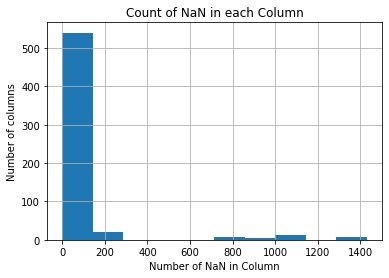

In [ ]:
# histogram of counts of number of NaN values in each column
import matplotlib.pyplot as plt
secomMerged.isna().sum().hist()
plt.title("Count of NaN in each Column")
plt.xlabel("Number of NaN in Column")
plt.ylabel("Number of columns")
print(f'Number of columns with more than 250 NaN: {sum(secomMerged.isna().sum() > 250)}')
totNumNaN = secomMerged.isna().sum().sum()
totNumValues = len(secomMerged) * (len(secomMerged.columns) - 2)
print(f'Total number of NaN in all columns: {totNumNaN}')
print(f'Percent of NaN out of all data:     {100*totNumNaN/totNumValues:0.2f}')

In [ ]:
# Do not fill the NaN with mean!  Missing NaN should be zero, because
# there is no data there; i.e., no sensor data
#secomMerged.fillna(secomMerged.mean(), inplace=True)
secomMerged  = secomMerged.replace(np.NaN, 0)  # replace NaN with zero
totNumNaN = secomMerged.isna().sum().sum()
print(f'Total number of NaN in all columns: {totNumNaN}')

Total number of NaN in all columns: 0


In [ ]:
secomMerged.describe()

,passFail,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589
count,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.0,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,...,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000
mean,0.066369,3002.910638,2484.700932,2180.887035,1383.901023,4.159516,99.106573,100.209538,0.121122,1.460995,-0.000840,0.000146,0.963122,199.701600,0.0,8.988130,412.295188,9.888635,0.969584,189.683511,12.401385,1.405054,-5611.222719,2695.933153,-3801.441661,-298.217028,1.202308,1.936003,6.630155,69.410828,2.363177,0.183924,3.668501,85.283010,8.954560,50.550359,64.514590,49.385834,66.179014,86.781161,...,14.190428,1.026509,0.230779,6.425630,0.420090,48.165108,3.517227,1.353767,0.994374,0.325500,0.072397,32.264353,216.957377,0.561235,5.322151,0.120242,2.156008,0.049618,2.025161,17.438590,530.523623,2.101836,28.450165,0.345636,9.162315,0.104729,5.563747,16.642363,0.008524,0.006637,0.002128,38.623767,0.499777,0.015308,0.003844,3.065869,0.021445,0.016464,0.005280,99.606461
std,0.249005,200.204648,184.815753,209.206773,458.937272,56.104457,9.412812,11.363940,0.012831,0.090461,0.015107,0.009296,0.036620,7.848224,0.0,2.821529,24.945317,2.440326,0.044155,8.762332,1.017643,0.016737,657.774591,310.647785,1385.963301,2900.855558,0.182620,0.201632,1.265856,4.257396,0.417084,0.033573,0.550829,2.958325,1.362954,1.740832,3.047065,1.719341,1.700279,2.238656,...,7.788334,1.324688,0.272464,3.496892,0.578109,38.672384,1.956756,1.811760,0.087520,0.201496,0.051594,19.037484,99.925253,0.280600,3.421456,0.092119,1.364539,0.037496,1.298442,12.260744,17.499736,0.275112,86.304681,0.248478,26.920150,0.067791,16.921369,12.485267,0.012879,0.010213,0.003284,72.871466,0.013084,0.017179,0.003721,3.577730,0.012366,0.008815,0.002869,93.895701
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.053400,-0.034900,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.179700,-7150.250000,0.000000,-9986.750000,-14804.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,317.196400,0.980200,3.540000,0.066700,1.039500,0.023000,0.663600,4.582000,-0.016900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.016900,0.000000,0.000000,0.000000
25%,0.000000,2965.670000,2451.515000,2180.700000,1080.116050,1.011000,100.000000,97.762200,0.121100,1.410950,-0.010800,-0.005600,0.958000,198.128450,0.0,7.080300,406.092900,9.565100,0.968100,188.291900,12.460000,1.396500,-5932.625000,2577.875000,-4370.625000,-1474.375000,1.093900,1.906150,5.262400,67.377800,2.088900,0.161700,3.362300,84.484350,8.580000,50.251500,64.024800,49.420500,66.040500,86.578300,...,13.415000,0.670000,0.065800,6.070750,0.273350,21.344000,3.318350,0.8

In [ ]:
# how many of each datatype columns do we have?
secomMerged.dtypes.value_counts()

float64           590
int64               1
datetime64[ns]      1
dtype: int64

In [ ]:
#These steps are now unnecessary because we now correctly read in the secom.data csv file.   
# allCols = set(secomMerged.columns)
# print(f'Number of total columns: {len(allCols)}')
# numericCols = sorted( allCols - set(['passFail', 'datetime']) )
# print(f'Number of numeric columns: {len(numericCols)}')
# # secomMerged2 = pd.to_numeric(secomMerged[ numericCols ], errors='coerce')
# secomMerged2 = secomMerged[ numericCols ].apply(pd.to_numeric, errors='coerce')
# secomMerged2['passFail'] = secomMerged['passFail'].astype('int64')
# secomMerged2['dateStamp'] = secomMerged['dateStamp'].str.replace(r'"', '').apply(parse)
# secomMerged2['timeStamp'] = secomMerged['timeStamp'].str.replace(r'"', '') #.apply(lambda x: parse(x).time)
# secomMerged2 = secomMerged2.loc[:, ['passFail','dateStamp','timeStamp'] + numericCols ]
# secomMerged2.head(10)

The NaNs in this dataset were stuborn. Below we take care of them using code adapted from:

https://www.kaggle.com/kuldeepsingharya/uci-secom

In [ ]:
#These steps are now unnecessary because we now correctly read in the secom.data csv file.   
# np.nan_to_num(secomMerged2)
# #sklearn.impute.SimpleImputer
# d = secomMerged2.isnull().sum()
# j = []
# for i in d.keys():
#     if(d[i] >900):
#         print(i, d[i])
#         j.append(i)
# secomMerged2.drop(j, inplace = True)
# secomMerged2.replace(np.nan, 0, inplace = True)
# #from sklearn.preprocessing import Imputer
# #imputer = Imputer(missing_values = np.nan, strategy = 'mean')
# secomMerged2.isnull().any().any()

In [ ]:
secomMerged.head(3)


,passFail,datetime,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589
0,0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,-0.0034,0.9455,202.4396,0.0,7.9558,414.8710,10.0433,0.9680,192.3963,12.5190,1.4026,-5419.00,2916.50,-4043.75,751.00,0.8955,1.7730,3.0490,64.2333,2.0222,0.1632,3.5191,83.3971,9.5126,50.6170,64.2588,49.3830,66.3141,...,12.93,0.78,0.1827,5.7349,0.3363,39.8842,3.2687,1.0297,1.0344,0.4385,0.1039,42.3877,0.000,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,533.8500,2.1113,8.95,0.3157,3.0624,0.1026,1.6765,14.9509,0.0000,0.0000,0.0000,0.0000,0.5005,0.0118,0.0035,2.3630,0.0000,0.0000,0.0000,0.0000
1,0,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,-0.0148,0.9627,200.5470,0.0,10.1548,414.7347,9.2599,0.9701,191.2872,12.4608,1.3825,-5441.50,2604.25,-3498.75,-1640.25,1.2973,2.0143,7.3900,68.4222,2.2667,0.2102,3.4171,84.9052,9.7997,50.6596,64.2828,49.3404,64.9193,...,16.00,1.33,0.2829,7.1196,0.4989,53.1836,3.9139,1.7819,0.9634,0.1745,0.0375,18.1087,0.000,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,535.0164,2.4335,5.92,0.2653,2.0111,0.0772,1.1065,10.9003,0.0096,0.0201,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,1,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,0.0013,0.9615,202.0179,0.0,9.5157,416.7075,9.3144,0.9674,192.7035,12.5404,1.4123,-5447.75,2701.75,-4047.00,-1916.50,1.3122,2.0295,7.5788,67.1333,2.3333,0.1734,3.5986,84.7569,8.6590,50.1530,64.1114,49.8470,65.8389,...,16.16,0.85,0.0857,7.1619,0.3752,23.0713,3.9306,1.1386,1.5021,0.3718,0.1233,24.7524,267.064,0.9032,1.1,0.6219,0.4122,0.2562,0.4119,68.8489,535.0245,2.0293,11.21,0.1882,4.0923,0.0640,2.0952,9.2721,0.0584,0.0484,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602


In [ ]:
#secomMerged.to_excel(r'secomMerged.xlsx', index = False)
#This cell no longer helpful. Have to resolve NaNs here. 
# secomMerged = pd.read_excel(r'secomMerged.xlsx',)

# Creating X and Y. Splitting data into training, testing, and validation sets.

First we create X and Y. For X we dropped the 

In [ ]:
# Creating X and Y before
# splitting data into training, testing, and validation sets.
X = secomMerged.drop(columns = ['passFail', 'datetime'])
X = X.astype('float32')
Y = secomMerged['passFail']

In [ ]:
# # Normalize all the columns in X to be between 0 and 1
# def norm(column):
#   return (column - min(column)) / (max(column) - min(column))

# # normalize all colunns in X
# for c in X.columns:
#   X[c] = norm(X[c])

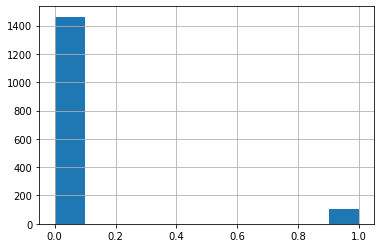

In [ ]:
#X.columns.values
Y.hist()

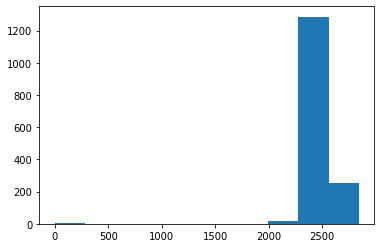

In [ ]:
from matplotlib import pyplot as plt
plt.hist(X[1])
plt.show()
#n = norm(X[1])
#plt.hist(n)
#plt.show()        

In [ ]:
# Test-validation-train split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=37)

# Split test into 50-50 test/validation
#X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=1)
#print('X valid stape: {}'.format(X_valid.shape))

print('X train shape: {}'.format(X_train.shape))
print('X test shape: {}'.format(X_test.shape))

X train shape: (1253, 590)
X test shape: (314, 590)


We move on to construct a simple feed forward neural network. This code was adapted from:

https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6

In [ ]:
#model.summary()
# f-string printing, whatever is in {} is run as regular python code
# the part :0.2f  means print out a decimal number (f==floating point number) that has 2 decimal places
print(f'Percent that are defects: {100* sum(y_train>0)/len(y_train):0.2f}') # percent defect (y_train == +1)
print(f'Total number in dataset: {len(y_train)}')

Percent that are defects: 6.62
Total number in dataset: 1253


In [ ]:
# double check count of NaN.  There should be none.
X_train.isna().sum().sum()

0

In [ ]:
# This is a very unbalanced data;  machine learning works best when balanced 
# i.e., closer to 50-50 of each class in 2 class problem
import imblearn
from imblearn.over_sampling import SMOTE
s = SMOTE(random_state=47)
X_balanced, y_balanced = s.fit_sample(X_train, y_train)
print(f'Percent that are defects: {100* sum(y_balanced>0)/len(y_balanced):0.2f}') 
print(f'Total number in dataset: {len(y_balanced)}')

Percent that are defects: 50.00
Total number in dataset: 2340


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
#################################################
## Using TensorFlow
import tensorflow as tf
from tensorflow import keras


In [ ]:
# Our first neural network
# Standard build feed forward neural network
# 1 hidden layer, but we could add more.

model = keras.Sequential()
model.add(keras.layers.Flatten()) # input layer;  flattens the input layer to a 1 dimensional vector
# Use dense layers == all nodes are connected to all nodes in the next layer 
model.add(keras.layers.Dense(10, activation=tf.nn.relu))  # hidden layer
model.add(keras.layers.Dense(2, activation=tf.nn.relu))    # output layer, 2 output: defective or not defective

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# train the model with the training set
model.fit(X_balanced, y_balanced, batch_size=128, epochs=5, validation_split=0.2 )

Epoch 1/5
15/15 [==============================] - 0s 11ms/step - loss: 2.1090 - accuracy: 0.5769 - val_loss: 0.7472 - val_accuracy: 0.2756
Epoch 2/5
15/15 [==============================] - 0s 4ms/step - loss: 1.3490 - accuracy: 0.5641 - val_loss: 0.6857 - val_accuracy: 0.3141
Epoch 3/5
15/15 [==============================] - 0s 3ms/step - loss: 1.2838 - accuracy: 0.5646 - val_loss: 0.6857 - val_accuracy: 0.3355
Epoch 4/5
15/15 [==============================] - 0s 3ms/step - loss: 1.2756 - accuracy: 0.5588 - val_loss: 0.6857 - val_accuracy: 0.3440
Epoch 5/5
15/15 [==============================] - 0s 3ms/step - loss: 1.0289 - accuracy: 0.5641 - val_loss: 0.6931 - val_accuracy: 0.2692


This model's accuracy is inconsistant. There are several instances where our model has terrible accuracy during training, but manages to get higher accuracy on the test set. 

In [ ]:
# check the accuracy of the test set
print("Evaluate the test data set.")
results = model.evaluate(X_test, y_test, batch_size=128 )
print(f'test loss (binary_crossentropy): {results[0]}')
print(f'test accuracy:                   {results[1]}')

Evaluate the test data set.
3/3 [==============================] - 0s 3ms/step - loss: 0.7423 - accuracy: 0.7134
test loss (binary_crossentropy): 0.7422713041305542
test accuracy:                   0.7133758068084717


In [ ]:
r = model.predict_classes(X_test)
#r

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


- top-left: true positives
- bottom-left: false positives
-top-right: false-negatives
bottom-right: true- negatives


In [ ]:
confusion_mat = tf.math.confusion_matrix(labels=y_test, predictions=r)
print(confusion_mat)
confusion_mat.numpy().max()

tf.Tensor(
[[219  74]
 [ 16   5]], shape=(2, 2), dtype=int32)


219

Next we plot our confusion matrix.

Confusion matrix, without normalization
[[219  74]
 [ 16   5]]


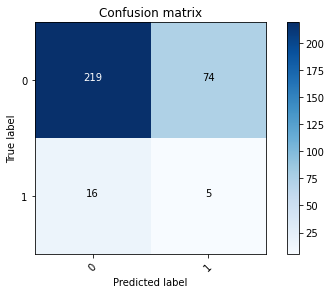

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

image = plot_confusion_matrix(confusion_mat.numpy(), classes=['0', '1'])

In [ ]:
np.isnan(X_balanced).sum()
print(sum(sum(X_balanced==0.0)))
X_balanced.shape[0] * X_balanced.shape[1]

346682


1380600

Above is our confusion matrix for the feed forward nerual network. We can see that the greatest share of samples are true-positives (i.e. predicted label 0, is true label 0). The number of class 1 diapers (i.e. defective) is much smaller, since the instance of faulty diapers is relatively rare-only 21 out of the 314 values in the decision tree. 

The following section is adapted from: 

1.   https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/neural_network.py
1.   https://caseythayerdotcom.files.wordpress.com/2019/09/predicting-manufacturing-failures-with-dense-and-recurrent-neural-networks.pdf







In [ ]:
# 2nd Model:  Dense neural network
# Standard build feed forward neural network with many Dense hidden layers

model = keras.Sequential()
model.add(keras.layers.Flatten()) # input layer;  flattens the input layer to a 1 dimensional vector
# Use dense layers == all nodes are connected to all nodes in the next layer 
model.add(keras.layers.Dense(64, activation=tf.nn.relu))  # hidden layer 1
model.add(keras.layers.Dense(64, activation=tf.nn.relu))  # hidden layer 2
model.add(keras.layers.Dense(16, activation=tf.nn.relu))  # hidden layer 3
model.add(keras.layers.Dense(2, activation=tf.nn.relu))   # output layer, 2 output: defective or not defective

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# train the model
model.fit(X_balanced, y_balanced, batch_size=64, epochs=2, validation_split=0.2 )

Epoch 1/2
30/30 [==============================] - 0s 7ms/step - loss: 1.5097 - accuracy: 0.6047 - val_loss: 0.6931 - val_accuracy: 0.0000e+00
Epoch 2/2
30/30 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.6250 - val_loss: 0.6931 - val_accuracy: 0.0000e+00


In [ ]:
# check the accuracy of the test set
print("Evaluate the test data set.")
results = model.evaluate(X_test, y_test, batch_size=128 )
print(f'test loss (binary_crossentropy): {results[0]}')
print(f'test accuracy:                   {results[1]}')

Evaluate the test data set.
3/3 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.9331
test loss (binary_crossentropy): 0.6931471824645996
test accuracy:                   0.9331210255622864


Confusion matrix, without normalization
[[293   0]
 [ 21   0]]


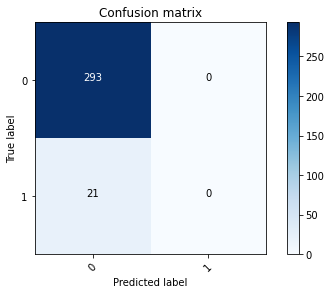

In [ ]:
r = model.predict_classes(X_test)
confusion_mat = tf.math.confusion_matrix(labels=y_test, predictions=r)
image = plot_confusion_matrix(confusion_mat.numpy(), classes=['0', '1'])

Once again, a very unreliable model. It seems to classify everything as one type and its accuracy scores swing drastically.









In [ ]:
# our second neural network
input_size = len(X.columns)
batch_size = 32
embedding_dim = 64
rnn_units = 64
model = keras.Sequential()
model.add(keras.layers.Embedding(input_size, embedding_dim, 
                                 batch_input_shape=[batch_size, None])) # input layer;  
#model.add(keras.layers.Flatten()) # input layer;  flattens the input layer to a 1 dimensional vector
# LSTM is a type of recurrent neural network layer
#model.add(keras.layers.LSTM(64))    #hidden layer
# different type of RNN layer
model.add(keras.layers.GRU(rnn_units, return_sequences=True, stateful=True, 
                           recurrent_initializer='glorot_uniform'))
# Use dense layers == all nodes are connected to all nodes in the next layer 
model.add(keras.layers.Dense(64, activation=tf.nn.relu))  # hidden layer
#model.add(keras.layers.Dense(2, activation=tf.nn.softmax))    # output layer, 2 output: defective or not defective

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
# reshape the resampled training features to feed into RNN 
X_balanced = X_balanced.reshape((X_balanced.shape[0], 1, X_balanced.shape[1]))

# convert test features from a dataframe to an array
X_test = X_test.to_numpy()

# reshape the test features to feed into RNN
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
# model = keras.Sequential()
# model.add(keras.layers.Embedding(input_dim=input_size, output_dim=64))
# # The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 256)
# model.add(keras.layers.GRU(256, return_sequences=True))
# # The output of SimpleRNN will be a 2D tensor of shape (batch_size, 128)
# model.add(keras.layers.SimpleRNN(128))
# model.add(keras.layers.Dense(2))

# model.compile(optimizer='sgd', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
#               metrics=['accuracy'])

# #print(model.summary())

model = keras.models.Sequential() 
model.add(keras.layers.SimpleRNN(128, input_shape=(X_balanced.shape[1], X_balanced.shape[2]), ))                          
model.add(keras.layers.LSTM(4))
model.add(keras.layers.Dense(1, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
# compile RNN model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


ValueError: ignored

In [ ]:
#model.summary()
X_balanced.shape
#np.isnan(X_balanced).sum()

(2340, 590)

In [ ]:
# train the model with the training set
model.fit(X_balanced, y_balanced, batch_size=batch_size, epochs=5, validation_split=0.2 )

Epoch 1/5


ValueError: ignored

In [ ]:
# check the accuracy of the test set

print("Evaluate the test data set.")
results = model.evaluate(X_test, y_test, batch_size=128 )
print(f'test loss (binary_crossentropy): {results[0]}')
print(f'test accuracy:                   {results[1]}')


Evaluate the test data set.


InvalidArgumentError: ignored

In [ ]:
confusion_mat = tf.math.confusion_matrix(labels=y_test, predictions=r)
image = plot_confusion_matrix(confusion_mat.numpy(), classes=['0', '1'])

# 5

Building these neural networks was an overall difficult task.

We successfully built a feed forward neural network and a dense neural network, although with inconsistent results. Sadly, we couldn't get our RNN to successfully run in the end. One thing that makes the RNNs more difficult, is the recurrent features that filters data back to itself. Also, the shape of the data presents more issues as it flows through the recurrent neural network than simpler neural networks that don't feed back on themselves in that way. 

### Things we could've done differently
- Spend more time with feature engineering, for example feature selection where we only use feature columns that were highly correlated to the target variable. Also, we could've scaled the numbers in the feature columns, e.g. linear scaling, log scaling, etc. We didn't do any of this. 
- Cleaning the data. All NaNs converted to zero. Would more thorough understanding of the features we could've selected more effective methods for dealing with those. For example convert to mean instead or entirely eliminate columns with too many NaNs in them.

Making a recommendation to the diaper manufacturer is a difficult task, especially when using semiconductor data. Perhaps for subsequent projects we could perform Principal Component Analysis to parce out which features to include in our model.



In [ ]:
"Disposable Diaper." madehow.com. Retrieved Sept. 2020, from http://www.madehow.com/Volume-3/Disposable-Diaper.html#google_vignette